In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna


In [27]:
df = pd.read_csv('../../df_analise_origem_LI.csv')

In [28]:
df.head()

,Data,Origem,VL Tabela,Vl Bruto,Vl Liquido Final,IPCA BR,IPCA ES,Taxa Ac. TRI % PIB,PMC - Número-índice (2022=100) (Número-índice)/ ES,PMC - Número-índice (2022=100) (Número-índice)/ BR,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES,PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES","PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR"
0,2020-01-31,LI - CONTATO - LINHARES,1285468.01,858277.51,722756.52,0.21,0.29,1.1,84.25384,95.01804,87.06581,97.86726,1.8,-1.9
1,2020-02-29,LI - CONTATO - LINHARES,1054996.90,709041.18,576162.49,0.25,0.33,1.1,81.61827,90.61413,86.78925,98.12855,-0.3,0.3
2,2020-03-31,LI - CONTATO - LINHARES,1022569.50,680837.41,548490.17,0.07,0.12,1.1,80.76074,90.34239,83.15137,93.91747,-4.2,-4.3
3,2020-04-30,LI - CONTATO - LINHARES,856549.92,532439.55,428851.29,-0.31,-0.09,-1.7,66.43382,75.01668,69.94442,79.16208,-15.9,-15.7
4,2020-05-31,LI - CONTATO - LINHARES,839236.45,532542.24,429685.14,-0.38,-0.48,-1.7,81.57634,86.89620,82.56763,88.37704,18.0,11.6


In [29]:
df.set_index('Data', inplace=True)    

if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp() 
else:
        df.index = pd.to_datetime(df.index)

In [30]:
# Verifique se há valores ausentes e preencha ou remova-os
df = df.dropna()

# Converta todas as colunas para tipos numéricos, se necessário
df = df.apply(pd.to_numeric, errors='coerce')

# Selecione as features (todas as colunas menos 'Vl Liquido Final', 'VL Tabela', 'Vl Bruto')
X = df.drop(columns=['Vl Liquido Final', 'Vl Bruto', 'VL Tabela', 'Origem', 'PMC - Número-índice (2022=100) (Número-índice)/ ES', 'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES', 'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES'])
y = df['Vl Liquido Final']

# Divida os dados em treinamento e teste
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]


In [31]:
print(f"Realizando otimização de hiperparâmetros para Linhares...")

# Definir a função objetivo para o Optuna
def objective(trial):
    # Definir o espaço de busca dos hiperparâmetros
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 3)
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q', 0, 3)
    s = 12  # Período sazonal fixo em 12 (mensal)

    try:
        # Treinar o modelo SARIMAX com os hiperparâmetros sugeridos
        model = SARIMAX(train_y, exog=train_X, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit(disp=False)
        
        # Fazer previsões no conjunto de teste
        forecast_test = model_fit.forecast(steps=len(test_y), exog=test_X)
        
        # Calcular o erro quadrático médio (RMSE)
        rmse = np.sqrt(mean_squared_error(test_y, forecast_test))
    except:
        # Em caso de erro na modelagem, retornar um valor grande
        rmse = np.inf

    return rmse

# Criar o estudo Optuna e executar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Obter os melhores hiperparâmetros
best_params = study.best_params
print("Melhores hiperparâmetros encontrados:")
print(best_params)


[I 2024-09-27 09:18:31,467] A new study created in memory with name: no-name-f1071691-c1eb-48cb-8e58-54b8e590272f


Realizando otimização de hiperparâmetros para Linhares...


C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
[I 2024-09-27 09:18:33,429] Trial 0 finished with value: 260170.22208701217 and parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 2, 'D': 2, 'Q': 1}. Best is trial 0 with value: 260170.22208701217.
C:\Users\fabia\AppData\Roaming\Python\Python312\s

Melhores hiperparâmetros encontrados:
{'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}


In [32]:
train_y.head()

Data
2020-01-31    722756.52
2020-02-29    576162.49
2020-03-31    548490.17
2020-04-30    428851.29
2020-05-31    429685.14
Name: Vl Liquido Final, dtype: float64

C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting p

Mean Absolute Error (MAE): 394371.13
Root Mean Squared Error (RMSE): 460423.35
Mean Absolute Percentage Error (MAPE): 49.90%
R-squared (R²): -3.95


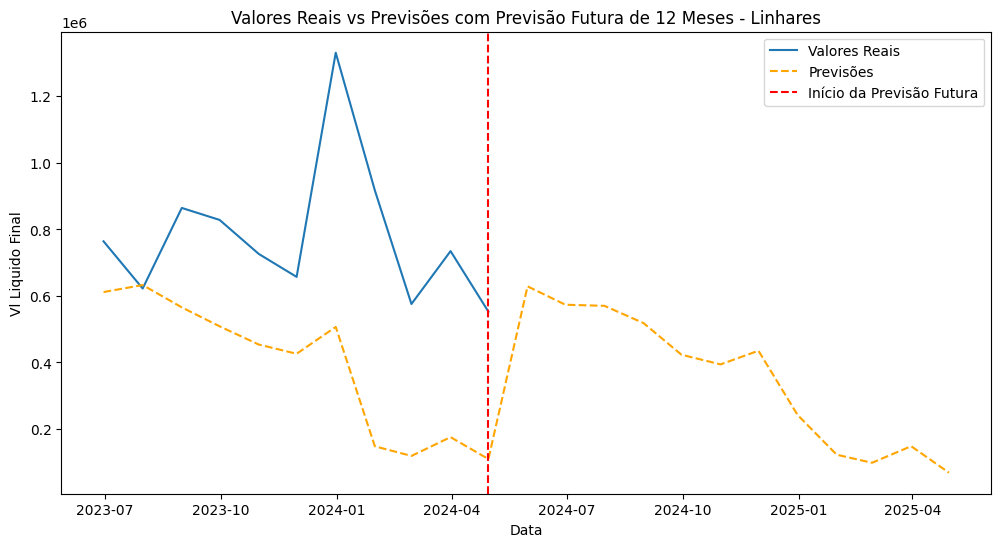

In [33]:
# model_best = SARIMAX(train_y, exog=train_X, order=(best_params['p'], best_params['d'], best_params['q']), 
#                      seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 12))
model_best = SARIMAX(train_y, exog=train_X, order=(0, 2, 1), 
                     seasonal_order=(2, 0, 2, 12))
model_best_fit = model_best.fit(disp=False)

# Previsão no conjunto de teste com o melhor modelo
forecast_test_best = model_best_fit.forecast(steps=len(test_y), exog=test_X)

# Previsão futura de 12 meses
future_steps = 12
future_dates = pd.date_range(start=test_y.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')
future_X = X.iloc[-future_steps:]  # Assumindo que você tenha dados futuros para as features

forecast_future_best = model_best_fit.forecast(steps=future_steps, exog=future_X)

# Combine previsões de teste e futuras
all_forecast_best = np.concatenate([forecast_test_best, forecast_future_best])
all_dates_best = test_y.index.append(future_dates)

# Calcule as métricas de avaliação
mae = mean_absolute_error(test_y, forecast_test_best)
rmse = np.sqrt(mean_squared_error(test_y, forecast_test_best))
mape = np.mean(np.abs((test_y - forecast_test_best) / test_y)) * 100
r2 = r2_score(test_y, forecast_test_best)

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

# Plotando os valores reais, as previsões e a previsão futura
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Valores Reais')
plt.plot(all_dates_best, all_forecast_best, label='Previsões', linestyle='--', color='orange')
plt.axvline(x=test_y.index[-1], color='red', linestyle='--', label='Início da Previsão Futura')
plt.xlabel('Data')
plt.ylabel('Vl Liquido Final')
plt.title(f'Valores Reais vs Previsões com Previsão Futura de 12 Meses - Linhares')
plt.legend()
plt.show()
